# Modèle prédictif pour classifier les attaques réseau - Methode 1
Nathan TBL

## • Importation des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires et définition des chemins et des colonnes pour les ensembles de données KDD

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

train_path = './datasets/KDD/KDDTrain+.txt'
test_path = './datasets/KDD/KDDTest+.txt'
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Mappage des étiquettes
label_mapping = {
    'benign': ['normal'],
    'probe': ['nmap', 'ipsweep', 'portsweep', 'satan', 'mscan', 'saint', 'worm'],
    'r2l': ['ftp_write', 'guess_passwd', 'snmpguess', 'imap', 'spy', 'warezclient', 'warezmaster', 'multihop', 'phf', 'named', 'sendmail', 'xlock', 'xsnoop', 'worm'],
    'u2r': ['ps', 'buffer_overflow', 'perl', 'rootkit', 'loadmodule', 'xterm', 'sqlattack', 'httptunnel'],
    'dos': ['apache2', 'back', 'mailbomb', 'processtable', 'snmpgetattack', 'teardrop', 'smurf', 'land', 'neptune', 'pod', 'udpstorm']
}

# Charger les ensembles de données
train_data = pd.read_csv(train_path, header=None, names=columns)
test_data = pd.read_csv(test_path, header=None, names=columns)


In [28]:
# Afficher les premières lignes des données d'entraînement
print("Premières lignes des données d'entraînement :")
train_data.head()

Premières lignes des données d'entraînement :


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [29]:
# Créer une copie des données d'entraînement pour le mappage des étiquettes
train_data_mapped = train_data.copy()

# Mapper les étiquettes aux catégories correspondantes dans la copie des données d'entraînement
for key, values in label_mapping.items():
    train_data_mapped.loc[train_data_mapped['label'].isin(values), 'label_mapped'] = key

# Afficher l'occurrence de chaque étiquette dans les données d'entraînement
print("\nOccurrences de chaque étiquette dans les données d'entraînement :")
print(train_data_mapped['label_mapped'].value_counts())



Occurrences de chaque étiquette dans les données d'entraînement :
benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: label_mapped, dtype: int64


## • Prétraitement des Données et Entraînement du Modèle
mappage des étiquettes en catégories, encodage des caractéristiques catégorielles, et normalisation des caractéristiques. Séparation des ensembles de formation et de validation. Définition de la fonction pour créer le modèle avec des paramètres spécifiques et entraînement du modèle sur les données d'entraînement et de validation.

In [30]:
# Mapper les étiquettes des attaques aux cinq catégories
def map_labels(label):
    for key, values in label_mapping.items():
        if label in values:
            return key
    return label

train_data['label'] = train_data['label'].apply(map_labels)
test_data['label'] = test_data['label'].apply(map_labels)

# Encoder les caractéristiques catégorielles
categorical_cols = ['protocol_type', 'service', 'flag']
train_data = pd.get_dummies(train_data, columns=categorical_cols)
test_data = pd.get_dummies(test_data, columns=categorical_cols)

# S'assurer que les ensembles de données de train et de test ont les mêmes colonnes après l'encodage
missing_cols = set(train_data.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data = test_data[train_data.columns]

# Séparer les caractéristiques et les étiquettes
X_train = train_data.drop(['label', 'difficulty'], axis=1)
y_train = train_data['label']
X_test = test_data.drop(['label', 'difficulty'], axis=1)
y_test = test_data['label']

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir les étiquettes en catégories
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Diviser les données de formation en ensembles de formation et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Définir les paramètres du modèle
model_params = {
    'activation': 'relu',
    'batch_size': 64,
    'dropout_rate': 0.0,
    'epochs': 20,
    'optimizer': 'SGD'
}

# Fonction pour créer le modèle
def create_model(activation='relu', dropout_rate=0.0, optimizer='SGD'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Créer le modèle avec les paramètres spécifiés
model = create_model(
    activation=model_params['activation'],
    dropout_rate=model_params['dropout_rate'],
    optimizer=model_params['optimizer']
)

# Entraîner le modèle avec les paramètres spécifiés 
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=model_params['batch_size'],
    epochs=model_params['epochs'],
    verbose=1
)



Train on 100778 samples, validate on 25195 samples
Epoch 1/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.1952 - acc: 0.9557 - val_loss: 0.0981 - val_acc: 0.9721
Epoch 2/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.0789 - acc: 0.9766 - val_loss: 0.0728 - val_acc: 0.9793
Epoch 3/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.0595 - acc: 0.9814 - val_loss: 0.0582 - val_acc: 0.9818
Epoch 4/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.0464 - acc: 0.9842 - val_loss: 0.0495 - val_acc: 0.9841
Epoch 5/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.0387 - acc: 0.9883 - val_loss: 0.0451 - val_acc: 0.9871
Epoch 6/20
100778/100778 [==============================] - 2s 20us/sample - loss: 0.0337 - acc: 0.9902 - val_loss: 0.0410 - val_acc: 0.9898
Epoch 7/20
100778/100778 [==============================] - 2s 21us/sample - loss: 0.0302 - acc: 0.9916

## • Évaluation du Modèle et Visualisation des Résultats
Évaluation du modèle sur les données de test en générant des prédictions et en calculant le rapport de classification. Visualisation des courbes de perte d'entraînement et de validation au fil des époques pour évaluer les performances du modèle pendant l'entraînement.

In [31]:
# Évaluer le  modèle
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [34]:
# Imprimer les paramètres utilisés et le rapport de classification final
print("\nParamètres utilisés pour cet entraînement :")
print(model_params)
print("\nRapport de classification final sur les données de test :")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))


Paramètres utilisés pour cet entraînement :
{'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 20, 'optimizer': 'SGD'}

Rapport de classification final sur les données de test :
              precision    recall  f1-score   support

      benign       0.68      0.93      0.79      9711
         dos       0.90      0.82      0.86      7636
       probe       0.84      0.66      0.74      2423
         r2l       0.96      0.10      0.17      2574
         u2r       0.81      0.11      0.19       200

    accuracy                           0.76     22544
   macro avg       0.84      0.53      0.55     22544
weighted avg       0.80      0.76      0.73     22544



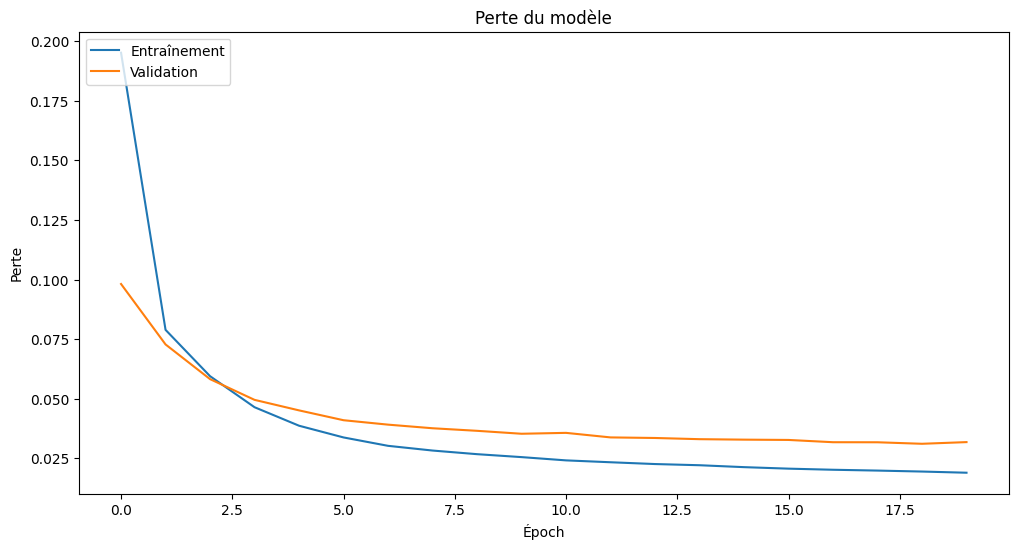

In [35]:
# Tracer les valeurs de perte d'entraînement et de validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époch')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()